In [ ]:
# Original simCLR Jupyternotebook that was used to train, evaluate and visualize. 
# Was split up to make it easier to look through.
# This file is for the case the split up file system doesn't work

In [1]:
pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00:00:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 46.8 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.10.19
    Uninstalling nvidia-curand-cu12-10.3.1

In [2]:
pip install pytorch-metric-learning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.8/127.8 kB 4.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import random
import os
import matplotlib.pyplot as plt
from datetime import datetime
import json
from pytorch_metric_learning.losses import NTXentLoss
from torchmetrics.segmentation import DiceScore
from torchmetrics.classification import JaccardIndex  # IoU
from torch.utils.data import ConcatDataset

import copy # for early stopper

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
seed = 42
random.seed(seed)

Using device: cuda


In [ ]:
# RESNET 50 Encoder
class ResNet50Encoder(nn.Module):
    """
    ResNet50 Encoder for simCLR decoder
    """
    def __init__(self, hidden_dim=512):
        super().__init__()
        
        # Load pre-trained ResNet50
        self.backbone = models.resnet50(pretrained=True)
        self.feature_dim = 2048
        
        # Remove the final classification layer
        self.backbone = nn.Sequential(*list(self.backbone.children())[:-2])
        
        # Global average pooling and projection
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(self.feature_dim, hidden_dim)
        
    def forward(self, x):
        features = self.backbone(x)
        pooled = self.global_pool(features)
        pooled = pooled.view(pooled.size(0), -1)
        return self.fc(pooled), features
    
    def get_layer_features(self, x):
        features = []
        
        # Initial conv and pooling
        x = self.backbone[0](x)  # conv1
        x = self.backbone[1](x)  # batchnormalization
        x = self.backbone[2](x)  # relu
        features.append(x)       # 64 channels, H/2 x W/2
        
        x = self.backbone[3](x)  # maxpool
        
        # ResNet blocks
        x = self.backbone[4](x)  # layer1
        features.append(x)       # 256 channels, H/4 x W/4
        
        x = self.backbone[5](x)  # layer2
        features.append(x)       # 512 channels, H/8 x W/8
        
        x = self.backbone[6](x)  # layer3
        features.append(x)       # 1024 channels, H/16 x W/16
        
        x = self.backbone[7](x)  # layer4
        features.append(x)       # 2048 channels, H/32 x W/32
        
        return features


# SimCLR Components

In [ ]:
class SimCLRAugmentation:
    """
    Augmentations for SimCLR
    """
    def __init__(self, size=256):
        self.transform = transforms.Compose([
            transforms.RandomResizedCrop(size, scale=(0.2, 1.0)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomApply([transforms.ColorJitter(brightness=0.4, contrast=0.4,saturation=0.4, hue=0.1)], p=0.8),
            transforms.RandomGrayscale(p=0.2),
            transforms.RandomApply([transforms.GaussianBlur(kernel_size=23)], p=0.5),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
    
    def __call__(self, x):
        return self.transform(x), self.transform(x)

In [ ]:
class ProjectionHead(nn.Module):
    """
    Projection head that projects encoded feature vector into lower-dimensional space
    """
    def __init__(self, input_dim=512, hidden_dim=512, output_dim=128):
        super().__init__()
        self.projection = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, output_dim)
        )
    
    def forward(self, x):
        return self.projection(x)

class SimCLRModel(nn.Module):
    """
    SimCLR model consisting of encoder and projection head for contrastive learning
    """
    def __init__(self, encoder, projection_head):
        super().__init__()
        self.encoder = encoder
        self.projection_head = projection_head
    
    def forward(self, x):
        h, _ = self.encoder(x)
        z = self.projection_head(h)
        return F.normalize(z, dim=1)


# U-Net Decoder

In [ ]:
class ResNet50UNetDecoder(nn.Module):
    """
    U-Net style decoder adapted to ResNet50 encoder features. Upsamples feature maps from encoder while using skip connections.
    """
    def __init__(self, num_classes=2):
        super().__init__()
        
        # Channel dimensions for ResNet50
        self.channels = [64, 256, 512, 1024, 2048]
        
        # Decoder blocks with skip connections
        self.up1 = nn.ConvTranspose2d(self.channels[4], self.channels[3], 2, stride=2)
        self.conv1 = self._make_conv_block(self.channels[3] * 2, self.channels[3])
        
        self.up2 = nn.ConvTranspose2d(self.channels[3], self.channels[2], 2, stride=2)
        self.conv2 = self._make_conv_block(self.channels[2] * 2, self.channels[2])
        
        self.up3 = nn.ConvTranspose2d(self.channels[2], self.channels[1], 2, stride=2)
        self.conv3 = self._make_conv_block(self.channels[1] * 2, self.channels[1])
        
        self.up4 = nn.ConvTranspose2d(self.channels[1], self.channels[0], 2, stride=2)
        self.conv4 = self._make_conv_block(self.channels[0] * 2, self.channels[0])
        
        # Final upsampling to original resolution
        self.up5 = nn.ConvTranspose2d(self.channels[0], 32, 2, stride=2)
        self.final_conv = nn.Conv2d(32, num_classes, 1)
        
    def _make_conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, features):
        # features: [feat1, feat2, feat3, feat4, feat5] from ResNet50 layers
        
        x = features[4]  # Start with deepest features (H/32 x W/32)
        
        # Decoder path with skip connections
        x = self.up1(x)  # H/16 x W/16
        x = torch.cat([x, features[3]], dim=1)
        x = self.conv1(x)
        
        x = self.up2(x)  # H/8 x W/8
        x = torch.cat([x, features[2]], dim=1)
        x = self.conv2(x)
        
        x = self.up3(x)  # H/4 x W/4
        x = torch.cat([x, features[1]], dim=1)
        x = self.conv3(x)
        
        x = self.up4(x)  # H/2 x W/2
        x = torch.cat([x, features[0]], dim=1)
        x = self.conv4(x)
        
        x = self.up5(x)  # H x W (original resolution)
        return self.final_conv(x)

class ResNet50SegmentationEncoder(nn.Module):
    """
    Encoder wrapper for feature extraction using (pretrained) ResNet50
    """
    def __init__(self, pretrained_encoder):
        super().__init__()
        self.resnet50_encoder = pretrained_encoder
        
    def forward(self, x):
        return self.resnet50_encoder.get_layer_features(x)

class TreeSegmentationModel(nn.Module):
    """
    Encoder-decoder model using ResNet50 for image segmentation
    """
    def __init__(self, pretrained_encoder, num_classes=2, freeze_early_layers=True):
        super().__init__()
        self.encoder = ResNet50SegmentationEncoder(pretrained_encoder)
        self.decoder = ResNet50UNetDecoder(num_classes)

        if freeze_early_layers:
            # Freeze first 2 ResNet blocks (keep low-level features)
            for param in self.encoder.resnet50_encoder.backbone[:6].parameters():
                param.requires_grad = False
                
    def forward(self, x):
        features = self.encoder(x)
        return self.decoder(features)


## DATASETS

In [9]:
class UnlabeledImageDataset(Dataset):
    def __init__(self, image_dir, transform=None, extensions=('.jpg', '.jpeg', '.png', '.tiff', '.tif')):
        """
        Dataset for unlabeled images (for SimCLR pre-training)
        """
        self.image_dir = image_dir
        self.transform = transform
        
        # Get all image files
        self.image_paths = []
        for file in os.listdir(image_dir):
            if file.lower().endswith(extensions):
                self.image_paths.append(os.path.join(image_dir, file))
        
        print(f"Found {len(self.image_paths)} images for pre-training")
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert('RGB')
        
        if self.transform:
            return self.transform(img)
        return img

class TreeSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, img_size=(256,256), augment=True, channels=(0,1,2)):

        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.img_size = img_size
        self.channels = channels
        
        self.img_resize = transforms.Resize(img_size)
        self.mask_resize = transforms.Resize(img_size, interpolation=transforms.InterpolationMode.NEAREST)

        # Aug (to PIL Images)
        if augment:
            self.joint_transform = transforms.Compose([
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomVerticalFlip(p=0.5),
                transforms.RandomRotation(degrees=10),
            ])
        else:
            self.joint_transform = None

        # To tensor, normalize
        self.to_tensor = transforms.ToTensor()
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                              std=[0.229, 0.224, 0.225])

 
        
        # Get matching image and mask files
        self.data_pairs = []
        image_files = {f.split('.')[0]: f for f in os.listdir(image_dir) 
                      if f.lower().endswith(('.jpg', '.jpeg', '.png', '.tiff', '.tif'))}
        mask_files = {f.split('.')[0]: f for f in os.listdir(mask_dir) 
                     if f.lower().endswith(('.jpg', '.jpeg', '.png', '.tiff', '.tif'))}
        
        # Find matching pairs
        for name in image_files:
            if name in mask_files:
                self.data_pairs.append((
                    os.path.join(image_dir, image_files[name]),
                    os.path.join(mask_dir, mask_files[name])
                ))
        
        print(f"Found {len(self.data_pairs)} image-mask pairs for segmentation")
    
    def __len__(self):
        return len(self.data_pairs)
    
    def __getitem__(self, idx):
        # Load real image and mask
        img_path, mask_path = self.data_pairs[idx]
        
        img = Image.open(img_path)
        mask = Image.open(mask_path).convert('L')  # Grayscale mask

        mask_np = np.array(mask)
        #print("Unique mask pixel values RAW:", np.unique(mask_np), mask_np.dtype)
        
        img = self.img_resize(img)
        mask = self.mask_resize(mask)
        
        # Apply joint transforms (rotation, flips) to both image and mask
        if self.joint_transform:
            # Use same random seed for both transforms
            seed = np.random.randint(2147483647)
            
            random.seed(seed)
            torch.manual_seed(seed)
            img = self.joint_transform(img)
            
            random.seed(seed)
            torch.manual_seed(seed)
            mask = self.joint_transform(mask)

         # To tensor (image: CxHxW, mask: 1xHxW)
        img_tensor = self.to_tensor(img)
        if img_tensor.shape[0] < (max(self.channels)+1):
            raise RuntimeError(f"Image has {img_tensor.shape[0]} channels, but tried to select channel {max(self.channels)+1}")

        
        img_tensor = img_tensor[list(self.channels), :, :]
        img_tensor = self.normalize(img_tensor)

        mask_tensor = self.to_tensor(mask)
        #for large dataset
        mask_tensor = (mask_tensor * 255).long().squeeze(0) 
        mask_tensor = (mask_tensor > 127).long()  # Threshold 
        
        # for goe dataset (Doesn't work yet)
        #mask_tensor = self.to_tensor(mask).long().squeeze(0) 
        #print("Unique mask_tensor thresholded:", torch.unique(mask_tensor))

        #print(torch.unique(mask_tensor))
        
        return img_tensor, mask_tensor
        

## DATALOADER

In [10]:
def create_dataloaders(image_dir=None, mask_dir=None, unlabeled_dir=None, unlabeled_dir2=None, 
                      batch_size_pretrain=32, batch_size_seg=16, 
                      img_size=(256, 256), num_workers=4):
    """
    Create data loaders for both pre-training and segmentation
    """
    
    # SimCLR pre-training data loader 
    pretrain_transform = SimCLRAugmentation(size=img_size[0])

    if unlabeled_dir2 is not None:
        # Concatenate datasets from both directories if available
        pretrain_dataset1 = UnlabeledImageDataset(
            image_dir=unlabeled_dir, 
            transform=pretrain_transform
        )
        pretrain_dataset2 = UnlabeledImageDataset(
            image_dir=unlabeled_dir2, 
            transform=pretrain_transform
        )
        pretrain_dataset = ConcatDataset([pretrain_dataset1, pretrain_dataset2])
    else:
        # Use just the first directory
        pretrain_dataset = UnlabeledImageDataset(
            image_dir=unlabeled_dir, 
            transform=pretrain_transform
        )

    pretrain_loader = DataLoader(
        pretrain_dataset, 
        batch_size=batch_size_pretrain, 
        shuffle=True, 
        num_workers=num_workers,
        pin_memory=True
    )
    
    # Segmentation data loader
    seg_dataset = TreeSegmentationDataset(
        image_dir=image_dir,
        mask_dir=mask_dir,
        img_size=img_size,
        augment=True
    )
    
    train_size = int(0.8 * len(seg_dataset))
    val_size = len(seg_dataset) - train_size
    generator = torch.Generator().manual_seed(42)
    seg_train_dataset, seg_val_dataset = torch.utils.data.random_split(seg_dataset, [train_size, val_size], generator=generator)
    
    seg_train_loader = DataLoader(
        seg_train_dataset, 
        batch_size=batch_size_seg, 
        shuffle=True, 
        num_workers=num_workers,
        pin_memory=True
    )
    seg_val_loader = DataLoader(
        seg_val_dataset, 
        batch_size=batch_size_seg, 
        shuffle=False, 
        num_workers=num_workers,
        pin_memory=True
    )
    
    return pretrain_loader, seg_train_loader, seg_val_loader

## TRAINING FUNCTIONS

In [ ]:
def train_simclr(model, dataloader, optimizer, criterion, device, epochs=50, accumulation_steps=8):
    """
    Training function for simCLR model, applies Gradient accumulation to simulate having larger batches
    """
    model.train()
    epoch_losses = []
    
    for epoch in range(epochs):
        total_loss = 0
        num_batches = 0
        
        # Clear gradients outside the batch loop
        optimizer.zero_grad()

        for batch_idx, (x_i, x_j) in enumerate(dataloader):
            x_i, x_j = x_i.to(device), x_j.to(device)
            
            z_i = model(x_i)
            z_j = model(x_j)
            z_i = F.normalize(z_i, dim=1)
            z_j = F.normalize(z_j, dim=1)
            
            embeddings = torch.cat([z_i, z_j], dim=0)  # [2B, D]
            labels = torch.arange(x_i.size(0), device=x_i.device)
            labels = torch.cat([labels, labels], dim=0)
            
            loss = criterion(embeddings, labels)
            # Normalize loss by accumulation steps
            loss = loss / accumulation_steps
            loss.backward()

            # Gradient Accumulation
            if (batch_idx + 1) % accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()
            
            total_loss += loss.item() * accumulation_steps  # Multiply back for logging
            num_batches += 1
            
            if batch_idx % 10 == 0:
                print(f'SimCLR Epoch {epoch+1}/{epochs}, Batch {batch_idx}, Loss: {loss.item() * accumulation_steps:.4f}')
        
        # If batches aren't divisible by accumulation_steps, step the optimizer once more
        if num_batches % accumulation_steps != 0:
            optimizer.step()
            optimizer.zero_grad()
        
        avg_loss = total_loss / num_batches
        epoch_losses.append(avg_loss)
        print(f'SimCLR Epoch {epoch+1}/{epochs} completed. Average Loss: {avg_loss:.4f}')
    
    return epoch_losses

def train_segmentation(model, dataloader, val_dataloader, optimizer, criterion, device, epochs=50, patience=10, min_delta=0.001, restore_best_weights=True):
    model.train()
    train_losses = []
    val_losses = []

    # Early stopping variables
    best_val_loss = float('inf')
    epochs_without_improvement = 0
    best_model_state = None
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        total_train_loss = 0
        num_batches = 0
        
        for batch_idx, (images, masks) in enumerate(dataloader):
            images, masks = images.to(device), masks.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.item()
            num_batches += 1
            
            if batch_idx % 50 == 0:
                print(f'Seg Epoch {epoch+1}/{epochs}, Batch {batch_idx}, Loss: {loss.item():.4f}')
        
        avg_train_loss = total_train_loss / num_batches
        train_losses.append(avg_train_loss)
        
        # Validation phase
        val_loss = 0
        if val_dataloader is not None:
            model.eval()
            val_loss = evaluate_segmentation_loss_only(model, val_dataloader, criterion, device)
            val_losses.append(val_loss)
            
        # Early stopping logic
            if val_loss < best_val_loss - min_delta:
                best_val_loss = val_loss
                epochs_without_improvement = 0
                if restore_best_weights:
                    best_model_state = copy.deepcopy(model.state_dict())
                print(f'Seg Epoch {epoch+1}/{epochs} completed. Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f} (Best)')
            else:
                epochs_without_improvement += 1
                print(f'Seg Epoch {epoch+1}/{epochs} completed. Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f} (No improvement: {epochs_without_improvement}/{patience})')
            
            # Check if we should stop early
            if epochs_without_improvement >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs. No improvement for {patience} epochs.')
                if restore_best_weights and best_model_state is not None:
                    model.load_state_dict(best_model_state)
                    print('Restored best model weights.')
                break
                
        else:
            print(f'Seg Epoch {epoch+1}/{epochs} completed. Train Loss: {avg_train_loss:.4f}')
    
    return train_losses, val_losses

def evaluate_segmentation_loss_only(model, dataloader, criterion, device):
    """Quick validation loss calculation without detailed metrics"""
    model.eval()
    total_loss = 0
    num_batches = 0
    
    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            total_loss += loss.item()
            num_batches += 1
    
    return total_loss / num_batches

def evaluate_segmentation(model, dataloader, device):
    model.eval()
    total_loss = 0
    correct_pixels = 0
    total_pixels = 0
    total_dice = 0
    total_iou = 0
    num_batches = 0
    
    criterion = nn.CrossEntropyLoss()
    # dice and IoU
    dice_metric = DiceScore(num_classes=2, average='macro', include_background = True).to(device)
    iou_metric = JaccardIndex(num_classes=2, task='multiclass', average='macro').to(device)
    
    # Reset metrics
    dice_metric.reset()
    iou_metric.reset()
    
    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, masks)
            total_loss += loss.item()
            
            # Calculate pixel accuracy
            predictions = torch.argmax(outputs, dim=1)
            correct_pixels += (predictions == masks).sum().item()
            total_pixels += masks.numel()
            
            # Calculate metrics per batch
            # Update metrics 
            dice_metric.update(predictions, masks)
            iou_metric.update(predictions, masks)
            
    avg_loss = total_loss / len(dataloader)
    pixel_accuracy = correct_pixels / total_pixels
    
    # Compute final metric values
    avg_dice_score = dice_metric.compute().item()
    avg_iou_score = iou_metric.compute().item()
    
    print(f"Validation Loss: {avg_loss:.4f}")
    print(f"Pixel Accuracy: {pixel_accuracy:.4f}")
    print(f"IoU: {avg_iou_score:.4f}")
    print(f"Dice Score: {avg_dice_score:.4f}")
    
    return avg_loss, pixel_accuracy, avg_iou_score, avg_dice_score



## Visualization

In [12]:
def plot_losses(simclr_losses, seg_losses, timestamp, save_dir='./'):
    """Plot and save loss curves for both training phases"""
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # SimCLR loss plot
    ax1.plot(simclr_losses, 'b-', linewidth=2, label='SimCLR Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('SimCLR Self-Supervised Pre-training Loss')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Segmentation loss plot
    if seg_losses:
        ax2.plot(seg_losses, 'r-', linewidth=2, label='Segmentation Loss')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Loss')
        ax2.set_title('Tree Segmentation Fine-tuning Loss')
        ax2.grid(True, alpha=0.3)
        ax2.legend()
    
    plt.tight_layout()
    
    # Save plot with timestamp
    plot_filename = f'{save_dir}training_losses_{timestamp}.png'
    plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
    print(f"Loss plot saved as: {plot_filename}")
    
    return plot_filename

def save_loss_data(simclr_losses, seg_losses, val_losses, timestamp, final_iou_score, final_dice_score, save_dir='./'):
    """Save loss data as JSON file"""
    
    loss_data = {
        'timestamp': timestamp,
        'simclr_losses': simclr_losses,
        'segmentation_losses': seg_losses,
        'validation_losses': val_losses,
        'num_simclr_epochs': len(simclr_losses),
        'num_seg_epochs': len(seg_losses) ,
        'final_iou_score': final_iou_score ,
        'final_dice_score': final_dice_score
    }
    
    json_filename = f'{save_dir}loss_data_{timestamp}.json'
    with open(json_filename, 'w') as f:
        json.dump(loss_data, f, indent=2)
    
    print(f"Loss data saved as: {json_filename}")
    return json_filename

# Baseline without simCLR

In [ ]:
class BaselineResNet50Encoder(nn.Module):
    """
    Baseline ResNet50 encoder that uses ImageNet pretrained weights
    without any SimCLR pretraining on the same dataset
    """
    def __init__(self):
        super().__init__()
        
        # Load ImageNet pre-trained ResNet50
        self.backbone = models.resnet50(pretrained=True)
        
        # Remove the final classification layer and global average pooling
        self.backbone = nn.Sequential(*list(self.backbone.children())[:-2])
        
    def get_layer_features(self, x):
        """Extract features from different layers for U-Net skip connections"""
        features = []
        
        # Initial conv and pooling
        x = self.backbone[0](x)  # conv1
        x = self.backbone[1](x)  # batchnorm1
        x = self.backbone[2](x)  # relu
        features.append(x)       # 64 channels, H/2 x W/2
        
        x = self.backbone[3](x)  # maxpool
        
        # ResNet blocks
        x = self.backbone[4](x)  # layer1
        features.append(x)       # 256 channels, H/4 x W/4
        
        x = self.backbone[5](x)  # layer2
        features.append(x)       # 512 channels, H/8 x W/8
        
        x = self.backbone[6](x)  # layer3
        features.append(x)       # 1024 channels, H/16 x W/16
        
        x = self.backbone[7](x)  # layer4
        features.append(x)       # 2048 channels, H/32 x W/32
        
        return features


# For Training without simCLR
class BaselineTreeSegmentationModel(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.encoder = BaselineResNet50Encoder()
        self.decoder = ResNet50UNetDecoder(num_classes)  # Reuse decoder
        
    def forward(self, x):
        features = self.encoder.get_layer_features(x)
        return self.decoder(features)

def train_baseline_segmentation(model, dataloader, val_dataloader, optimizer, criterion, device, epochs=50, patience=10, min_delta=0.001, restore_best_weights=True):
    """
    Training function for baseline segmentation model (ImageNet pretrained only)
    Identical to train_segmentation but with baseline-specific logging
    """
    model.train()
    train_losses = []
    val_losses = []

    # Early stopping variables
    best_val_loss = float('inf')
    epochs_without_improvement = 0
    best_model_state = None
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        total_train_loss = 0
        num_batches = 0
        
        for batch_idx, (images, masks) in enumerate(dataloader):
            images, masks = images.to(device), masks.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.item()
            num_batches += 1
            
            if batch_idx % 50 == 0:
                print(f'Baseline Epoch {epoch+1}/{epochs}, Batch {batch_idx}, Loss: {loss.item():.4f}')
        
        avg_train_loss = total_train_loss / num_batches
        train_losses.append(avg_train_loss)
        
        # Validation phase
        val_loss = 0
        if val_dataloader is not None:
            model.eval()
            val_loss = evaluate_baseline_loss_only(model, val_dataloader, criterion, device)
            val_losses.append(val_loss)
            
        # Early stopping logic
            if val_loss < best_val_loss - min_delta:
                best_val_loss = val_loss
                epochs_without_improvement = 0
                if restore_best_weights:
                    best_model_state = copy.deepcopy(model.state_dict())
                print(f'Baseline Epoch {epoch+1}/{epochs} completed. Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f} (Best)')
            else:
                epochs_without_improvement += 1
                print(f'Baseline Epoch {epoch+1}/{epochs} completed. Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f} (No improvement: {epochs_without_improvement}/{patience})')
            
            # Check if we should stop early
            if epochs_without_improvement >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs. No improvement for {patience} epochs.')
                if restore_best_weights and best_model_state is not None:
                    model.load_state_dict(best_model_state)
                    print('Restored best model weights.')
                break
                
        else:
            print(f'Baseline Epoch {epoch+1}/{epochs} completed. Train Loss: {avg_train_loss:.4f}')
    
    return train_losses, val_losses

def evaluate_baseline_loss_only(model, dataloader, criterion, device):
    """Quick validation loss calculation for baseline model"""
    model.eval()
    total_loss = 0
    num_batches = 0
    
    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            total_loss += loss.item()
            num_batches += 1
    
    return total_loss / num_batches

def evaluate_baseline_segmentation(model, dataloader, device):
    """
    Evaluation function for baseline model
    """
    model.eval()
    total_loss = 0
    correct_pixels = 0
    total_pixels = 0
    num_batches = 0
    
    criterion = nn.CrossEntropyLoss()
    # dice and IoU
    dice_metric = DiceScore(num_classes=2, average='macro', include_background=True).to(device)
    iou_metric = JaccardIndex(num_classes=2, task='multiclass', average='macro').to(device)
    
    # Reset metrics
    dice_metric.reset()
    iou_metric.reset()
    
    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, masks)
            total_loss += loss.item()
            
            # Calculate pixel accuracy
            predictions = torch.argmax(outputs, dim=1)
            correct_pixels += (predictions == masks).sum().item()
            total_pixels += masks.numel()
            
            # Update metrics 
            dice_metric.update(predictions, masks)
            iou_metric.update(predictions, masks)
            
    avg_loss = total_loss / len(dataloader)
    pixel_accuracy = correct_pixels / total_pixels
    
    # Compute final metric values
    avg_dice_score = dice_metric.compute().item()
    avg_iou_score = iou_metric.compute().item()
    
    print(f"Baseline Validation Loss: {avg_loss:.4f}")
    print(f"Baseline Pixel Accuracy: {pixel_accuracy:.4f}")
    print(f"Baseline IoU: {avg_iou_score:.4f}")
    print(f"Baseline Dice Score: {avg_dice_score:.4f}")
    
    return avg_loss, pixel_accuracy, avg_iou_score, avg_dice_score


## Model training Start

In [14]:
# Create timestamp for this training run
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
print(f"Training run timestamp: {timestamp}")

# Data directories
data_config = {
    'unlabeled_dir': '/kaggle/input/training-data/Training_data/aerial_unlabeled',  # For SimCLR pre-training
    'image_dir': '/kaggle/input/small-split-binary/small_split_binary/images',                # Labeled images for segmentation
    #'unlabeled_dir2': '/kaggle/input/gta-dataset/GTA-V/tiles',
    'mask_dir': '/kaggle/input/small-split-binary/small_split_binary/masks',                  # Corresponding segmentation masks
    'batch_size_pretrain': 32,
    'batch_size_seg': 16,
    'img_size': (256, 256),  
    'num_workers': 4 
}

# Create data loaders
print("Creating data loaders...")
pretrain_loader, seg_train_loader, seg_val_loader = create_dataloaders(**data_config)

Training run timestamp: 20250825_143730
Creating data loaders...
Found 1000 images for pre-training
Found 16176 image-mask pairs for segmentation


In [15]:

print("=" * 60)
print("BASELINE: ImageNet pretrained ResNet50 + U-Net (No SimCLR)")
print("=" * 60)

# Create baseline model (ImageNet pretrained only)
baseline_model = BaselineTreeSegmentationModel(num_classes=2).to(device)
baseline_optimizer = torch.optim.Adam(baseline_model.parameters(), lr=1e-4, weight_decay=1e-5)
baseline_criterion = nn.CrossEntropyLoss()

# Train baseline model
baseline_train_losses, baseline_val_losses = train_baseline_segmentation(
    baseline_model, seg_train_loader, seg_val_loader, 
    baseline_optimizer, baseline_criterion, device, epochs=15, patience=5
)

# Evaluate baseline model
if seg_val_loader is not None:
    print("Final evaluation on validation set (Baseline)")
    baseline_val_loss, baseline_pixel_acc, baseline_iou_score, baseline_dice_score = evaluate_baseline_segmentation(
        baseline_model, seg_val_loader, device
    )


BASELINE: ImageNet pretrained ResNet50 + U-Net (No SimCLR)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 221MB/s]


Baseline Epoch 1/15, Batch 0, Loss: 0.6847
Baseline Epoch 1/15, Batch 50, Loss: 0.4442
Baseline Epoch 1/15, Batch 100, Loss: 0.3196
Baseline Epoch 1/15, Batch 150, Loss: 0.3988
Baseline Epoch 1/15, Batch 200, Loss: 0.2770
Baseline Epoch 1/15, Batch 250, Loss: 0.2651
Baseline Epoch 1/15, Batch 300, Loss: 0.2302
Baseline Epoch 1/15, Batch 350, Loss: 0.2646
Baseline Epoch 1/15, Batch 400, Loss: 0.1877
Baseline Epoch 1/15, Batch 450, Loss: 0.2447
Baseline Epoch 1/15, Batch 500, Loss: 0.2871
Baseline Epoch 1/15, Batch 550, Loss: 0.1875
Baseline Epoch 1/15, Batch 600, Loss: 0.2119
Baseline Epoch 1/15, Batch 650, Loss: 0.1599
Baseline Epoch 1/15, Batch 700, Loss: 0.1445
Baseline Epoch 1/15, Batch 750, Loss: 0.1357
Baseline Epoch 1/15, Batch 800, Loss: 0.1179
Baseline Epoch 1/15 completed. Train Loss: 0.2847, Val Loss: 0.1995 (Best)
Baseline Epoch 2/15, Batch 0, Loss: 0.1649
Baseline Epoch 2/15, Batch 50, Loss: 0.1143
Baseline Epoch 2/15, Batch 100, Loss: 0.1475
Baseline Epoch 2/15, Batch 150,

In [16]:
print("\n" + "=" * 60)
print("SIMCLR PRETRAINED MODEL")
print("=" * 60)

# Initialize models for SimCLR
encoder = ResNet50Encoder(hidden_dim=512)
projection_head = ProjectionHead(input_dim=512, hidden_dim=512, output_dim=128)
simclr_model = SimCLRModel(encoder, projection_head).to(device)

print("Phase 1: Self-supervised pre-training with SimCLR")

# Train SimCLR
optimizer = torch.optim.Adam(simclr_model.parameters(), lr=1e-3, weight_decay=1e-6)
criterion = NTXentLoss(temperature = 0.5)

simclr_losses = train_simclr(simclr_model, pretrain_loader, optimizer, criterion, device, epochs=50)


SIMCLR PRETRAINED MODEL
Phase 1: Self-supervised pre-training with SimCLR
SimCLR Epoch 1/50, Batch 0, Loss: 3.9986
SimCLR Epoch 1/50, Batch 10, Loss: 3.8893
SimCLR Epoch 1/50, Batch 20, Loss: 3.4342
SimCLR Epoch 1/50, Batch 30, Loss: 3.3596
SimCLR Epoch 1/50 completed. Average Loss: 3.5899
SimCLR Epoch 2/50, Batch 0, Loss: 3.4257
SimCLR Epoch 2/50, Batch 10, Loss: 3.4486
SimCLR Epoch 2/50, Batch 20, Loss: 3.3422
SimCLR Epoch 2/50, Batch 30, Loss: 3.1438
SimCLR Epoch 2/50 completed. Average Loss: 3.2346
SimCLR Epoch 3/50, Batch 0, Loss: 3.1633
SimCLR Epoch 3/50, Batch 10, Loss: 3.2860
SimCLR Epoch 3/50, Batch 20, Loss: 3.1023
SimCLR Epoch 3/50, Batch 30, Loss: 3.0718
SimCLR Epoch 3/50 completed. Average Loss: 3.0702
SimCLR Epoch 4/50, Batch 0, Loss: 3.0430
SimCLR Epoch 4/50, Batch 10, Loss: 3.0141
SimCLR Epoch 4/50, Batch 20, Loss: 2.9395
SimCLR Epoch 4/50, Batch 30, Loss: 2.9349
SimCLR Epoch 4/50 completed. Average Loss: 2.9352
SimCLR Epoch 5/50, Batch 0, Loss: 2.9085
SimCLR Epoch 5/5

In [17]:
print("Phase 2: Fine-tuning for tree segmentation")

# Create segmentation model using pre-trained encoder
seg_model = TreeSegmentationModel(simclr_model.encoder, num_classes=2).to(device)

# Fine-tune for segmentation
seg_optimizer = torch.optim.Adam(seg_model.parameters(), lr=1e-4, weight_decay=1e-5)
seg_criterion = nn.CrossEntropyLoss()

seg_train_losses, seg_val_losses = train_segmentation(seg_model, seg_train_loader, seg_val_loader, 
                                                     seg_optimizer, seg_criterion, device, epochs=50, patience=5)

Phase 2: Fine-tuning for tree segmentation
Seg Epoch 1/50, Batch 0, Loss: 0.7012
Seg Epoch 1/50, Batch 50, Loss: 0.5138
Seg Epoch 1/50, Batch 100, Loss: 0.3893
Seg Epoch 1/50, Batch 150, Loss: 0.3270
Seg Epoch 1/50, Batch 200, Loss: 0.3588
Seg Epoch 1/50, Batch 250, Loss: 0.2680
Seg Epoch 1/50, Batch 300, Loss: 0.2190
Seg Epoch 1/50, Batch 350, Loss: 0.2794
Seg Epoch 1/50, Batch 400, Loss: 0.2022
Seg Epoch 1/50, Batch 450, Loss: 0.3291
Seg Epoch 1/50, Batch 500, Loss: 0.3074
Seg Epoch 1/50, Batch 550, Loss: 0.2865
Seg Epoch 1/50, Batch 600, Loss: 0.1919
Seg Epoch 1/50, Batch 650, Loss: 0.3248
Seg Epoch 1/50, Batch 700, Loss: 0.1111
Seg Epoch 1/50, Batch 750, Loss: 0.1701
Seg Epoch 1/50, Batch 800, Loss: 0.2469
Seg Epoch 1/50 completed. Train Loss: 0.3158, Val Loss: 0.2232 (Best)
Seg Epoch 2/50, Batch 0, Loss: 0.2748
Seg Epoch 2/50, Batch 50, Loss: 0.3537
Seg Epoch 2/50, Batch 100, Loss: 0.2716
Seg Epoch 2/50, Batch 150, Loss: 0.2312
Seg Epoch 2/50, Batch 200, Loss: 0.2159
Seg Epoch 2/5

In [ ]:
# Additional helper functions for comparison plotting and data saving
def plot_losses_comparison(simclr_losses, seg_train_losses, baseline_train_losses, timestamp):
    """
    Modified plotting function to compare baseline vs SimCLR results
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # SimCLR losses
    axes[0].plot(simclr_losses, 'b-', label='SimCLR Loss')
    axes[0].set_title('SimCLR Pre-training Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)
    
    # Segmentation losses comparison
    axes[1].plot(baseline_train_losses, 'r-', label='Baseline (ImageNet)')
    axes[1].plot(seg_train_losses, 'g-', label='SimCLR Pretrained')
    axes[1].set_title('Segmentation Training Loss Comparison')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True)
    
    # Final metrics comparison
    metrics = ['IoU', 'Dice', 'Pixel Acc']
    baseline_vals = [baseline_iou_score, baseline_dice_score, baseline_pixel_acc]
    simclr_vals = [final_iou_score, final_dice_score, final_pixel_acc]
    
    x = range(len(metrics))
    width = 0.35
    axes[2].bar([i - width/2 for i in x], baseline_vals, width, label='Baseline', color='red', alpha=0.7)
    axes[2].bar([i + width/2 for i in x], simclr_vals, width, label='SimCLR', color='green', alpha=0.7)
    axes[2].set_title('Final Metrics Comparison')
    axes[2].set_xlabel('Metrics')
    axes[2].set_ylabel('Score')
    axes[2].set_xticks(x)
    axes[2].set_xticklabels(metrics)
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plot_filename = f'training_comparison_{timestamp}.png'
    plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
    plt.show()
    
    return plot_filename

def save_comparison_data(simclr_losses, seg_train_losses, seg_val_losses, final_iou_score, final_dice_score,
                        baseline_train_losses, baseline_val_losses, baseline_iou_score, baseline_dice_score,
                        timestamp):
    """
    Save comparison data as JSON
    """
    data = {
        'timestamp': timestamp,
        'simclr_model': {
            'simclr_losses': simclr_losses,
            'seg_train_losses': seg_train_losses,
            'seg_val_losses': seg_val_losses,
            'final_iou_score': final_iou_score,
            'final_dice_score': final_dice_score
        },
        'baseline_model': {
            'train_losses': baseline_train_losses,
            'val_losses': baseline_val_losses,
            'final_iou_score': baseline_iou_score,
            'final_dice_score': baseline_dice_score
        },
        'improvement': {
            'iou_improvement_percent': ((final_iou_score - baseline_iou_score) / baseline_iou_score) * 100,
            'dice_improvement_percent': ((final_dice_score - baseline_dice_score) / baseline_dice_score) * 100
        }
    }
    
    json_filename = f'training_comparison_data_{timestamp}.json'
    with open(json_filename, 'w') as f:
        json.dump(data, f, indent=2)
    
    return json_filename

Final evaluation on validation set
Validation Loss: 0.1503
Pixel Accuracy: 0.9381
IoU: 0.8677
Dice Score: 0.3876

TRAINING COMPARISON RESULTS

Baseline Model Results:
  Final train loss: 0.1314
  Final val loss: 0.1485
  Final pixel accuracy: 0.9423
  Final IoU score: 0.8750
  Final Dice score: 0.3873

SimCLR Pretrained Model Results:
  SimCLR final loss: 2.5243
  Segmentation final train loss: 0.1393
  Segmentation final val loss: 0.1462
  Final pixel accuracy: 0.9381
  Final IoU score: 0.8677
  Final Dice score: 0.3876

Improvement with SimCLR pretraining:
  IoU improvement: -0.84%
  Dice improvement: +0.06%
  Pixel accuracy improvement: -0.45%


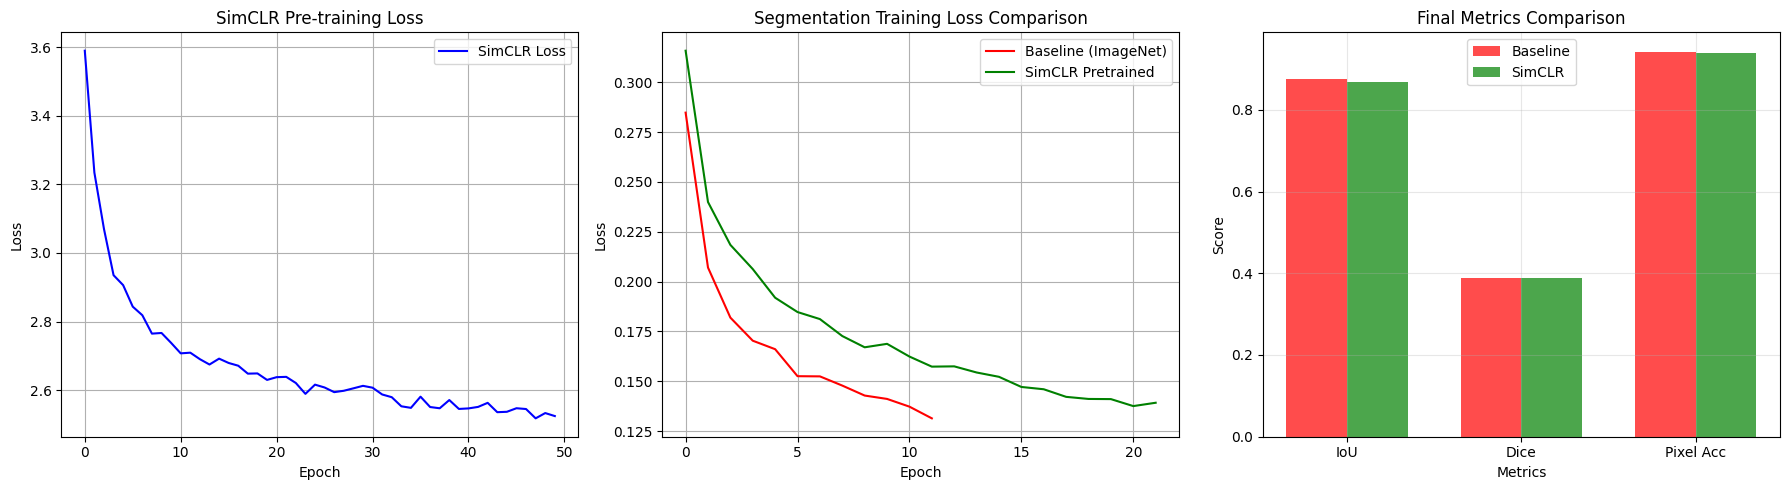


Models saved:
  Baseline: baseline_tree_segmentation_model_20250825_143730.pth
  SimCLR: simclr_pretrained_resnet50_20250825_143730.pth
  Segmentation: tree_segmentation_model_resnet50_20250825_143730.pth


In [ ]:
# Final validation if available
if seg_val_loader is not None:
    print("Final evaluation on validation set")
    final_val_loss, final_pixel_acc, final_iou_score, final_dice_score = evaluate_segmentation(seg_model, seg_val_loader, device)


# ===== COMPARISON AND RESULTS =====
print("\n" + "=" * 60)
print("TRAINING COMPARISON RESULTS")
print("=" * 60)

# Print comparison summary
print(f"\nBaseline Model Results:")
print(f"  Final train loss: {baseline_train_losses[-1]:.4f}")
if baseline_val_losses:
    print(f"  Final val loss: {baseline_val_losses[-1]:.4f}")
if seg_val_loader is not None:
    print(f"  Final pixel accuracy: {baseline_pixel_acc:.4f}")
    print(f"  Final IoU score: {baseline_iou_score:.4f}")
    print(f"  Final Dice score: {baseline_dice_score:.4f}")

print(f"\nSimCLR Pretrained Model Results:")
print(f"  SimCLR final loss: {simclr_losses[-1]:.4f}")
print(f"  Segmentation final train loss: {seg_train_losses[-1]:.4f}")
if seg_val_losses:
    print(f"  Segmentation final val loss: {seg_val_losses[-1]:.4f}")
if seg_val_loader is not None:
    print(f"  Final pixel accuracy: {final_pixel_acc:.4f}")
    print(f"  Final IoU score: {final_iou_score:.4f}")
    print(f"  Final Dice score: {final_dice_score:.4f}")

# Calculate improvement
if seg_val_loader is not None:
    iou_improvement = ((final_iou_score - baseline_iou_score) / baseline_iou_score) * 100
    dice_improvement = ((final_dice_score - baseline_dice_score) / baseline_dice_score) * 100
    acc_improvement = ((final_pixel_acc - baseline_pixel_acc) / baseline_pixel_acc) * 100
    
    print(f"\nImprovement with SimCLR pretraining:")
    print(f"  IoU improvement: {iou_improvement:+.2f}%")
    print(f"  Dice improvement: {dice_improvement:+.2f}%")
    print(f"  Pixel accuracy improvement: {acc_improvement:+.2f}%")

# Create and save loss plots 
plot_filename = plot_losses_comparison(simclr_losses, seg_train_losses, baseline_train_losses, timestamp)

# Save loss data as JSON with comparison
json_filename = save_comparison_data(
    simclr_losses, seg_train_losses, seg_val_losses, final_iou_score, final_dice_score,
    baseline_train_losses, baseline_val_losses, baseline_iou_score, baseline_dice_score,
    timestamp
)

# Save models with timestamp
baseline_model_path = f'baseline_tree_segmentation_model_{timestamp}.pth'
simclr_model_path = f'simclr_pretrained_resnet50_{timestamp}.pth'
seg_model_path = f'tree_segmentation_model_resnet50_{timestamp}.pth'

torch.save(baseline_model.state_dict(), baseline_model_path)
torch.save(simclr_model.state_dict(), simclr_model_path)
torch.save(seg_model.state_dict(), seg_model_path)

print(f"\nModels saved:")
print(f"  Baseline: {baseline_model_path}")
print(f"  SimCLR: {simclr_model_path}")
print(f"  Segmentation: {seg_model_path}")

In [20]:
def visualize_segmentation_results_colored(model, val_dataloader, device, num_images=5):
    model.eval()
    
    fig, axes = plt.subplots(num_images, 3, figsize=(15, num_images * 5))
    if num_images == 1:
        axes = axes.reshape(1, -1)
    
    # Titles
    axes[0, 0].set_title('Original Image', fontsize=14, fontweight='bold')
    axes[0, 1].set_title('Ground Truth Mask', fontsize=14, fontweight='bold')
    axes[0, 2].set_title('Predicted Mask', fontsize=14, fontweight='bold')
    
    accuracies = []
    dices = []
    ious = []
    
    with torch.no_grad():
        image_count = 0
        for batch_idx, (images, masks) in enumerate(val_dataloader):
            images, masks = images.to(device), masks.to(device)
            
            outputs = model(images)
            predictions = torch.argmax(outputs, dim=1)
            
            batch_size = images.size(0)
            for j in range(batch_size):
                if image_count >= num_images:
                    break
                
                image = images[j].cpu()
                true_mask = masks[j].cpu()
                pred_mask = predictions[j].cpu()
                
                correct_pixels = (true_mask == pred_mask).sum().item()
                total_pixels = true_mask.numel()
                accuracy = correct_pixels / total_pixels * 100
                accuracies.append(accuracy)
                
                # Initialize metric objects for this single image
                dice_metric = DiceScore(num_classes=2, average='macro', include_background=True).to(device)
                iou_metric = JaccardIndex(num_classes=2, task='multiclass', average='macro').to(device)
                
                # Add batch dimension and move to device
                p = pred_mask.unsqueeze(0).to(device)
                t = true_mask.unsqueeze(0).to(device)
                
                dice_metric.update(p, t)
                iou_metric.update(p, t)
                
                dice_val = dice_metric.compute().item()
                iou_val = iou_metric.compute().item()
                
                dices.append(dice_val)
                ious.append(iou_val)
                
                i = image_count
                
                if image.shape[0] == 3:
                    image_np = image.permute(1, 2, 0).numpy()
                    mean = np.array([0.485, 0.456, 0.406])
                    std = np.array([0.229, 0.224, 0.225])
                    image_np = std * image_np + mean
                    image_np = np.clip(image_np, 0, 1)
                else:
                    image_np = image.squeeze().numpy()
                
                axes[i, 0].imshow(image_np if len(image_np.shape)==3 else image_np, cmap=None if len(image_np.shape)==3 else 'gray')
                axes[i, 0].axis('off')
                axes[i, 1].imshow(true_mask.numpy(), cmap='viridis', alpha=0.8)
                axes[i, 1].axis('off')
                axes[i, 2].imshow(pred_mask.numpy(), cmap='viridis', alpha=0.8)
                axes[i, 2].axis('off')
                
                axes[i, 0].set_ylabel(
                    f'Image {image_count + 1}\nAcc: {accuracy:.1f}%', fontsize=12, fontweight='bold'
                )
                
                image_count += 1
            
            if image_count >= num_images:
                break
    
    plt.tight_layout()
    plt.show()
    
    # Print textual table of the metrics per image
    print("\nPer-Image Segmentation Metrics:")
    print(f"{'Image':<8}{'Pixel Acc (%)':<15}{'Dice Score':<12}{'IoU Score':<12}")
    print("-" * 47)
    for idx in range(num_images):
        print(f"{idx+1:<8}{accuracies[idx]:<15.2f}{dices[idx]:<12.4f}{ious[idx]:<12.4f}")
    
    print(f"\nAverage Pixel Accuracy: {np.mean(accuracies):.2f}%")
    print(f"Average Dice Score: {np.mean(dices):.4f}")
    print(f"Average IoU Score: {np.mean(ious):.4f}")

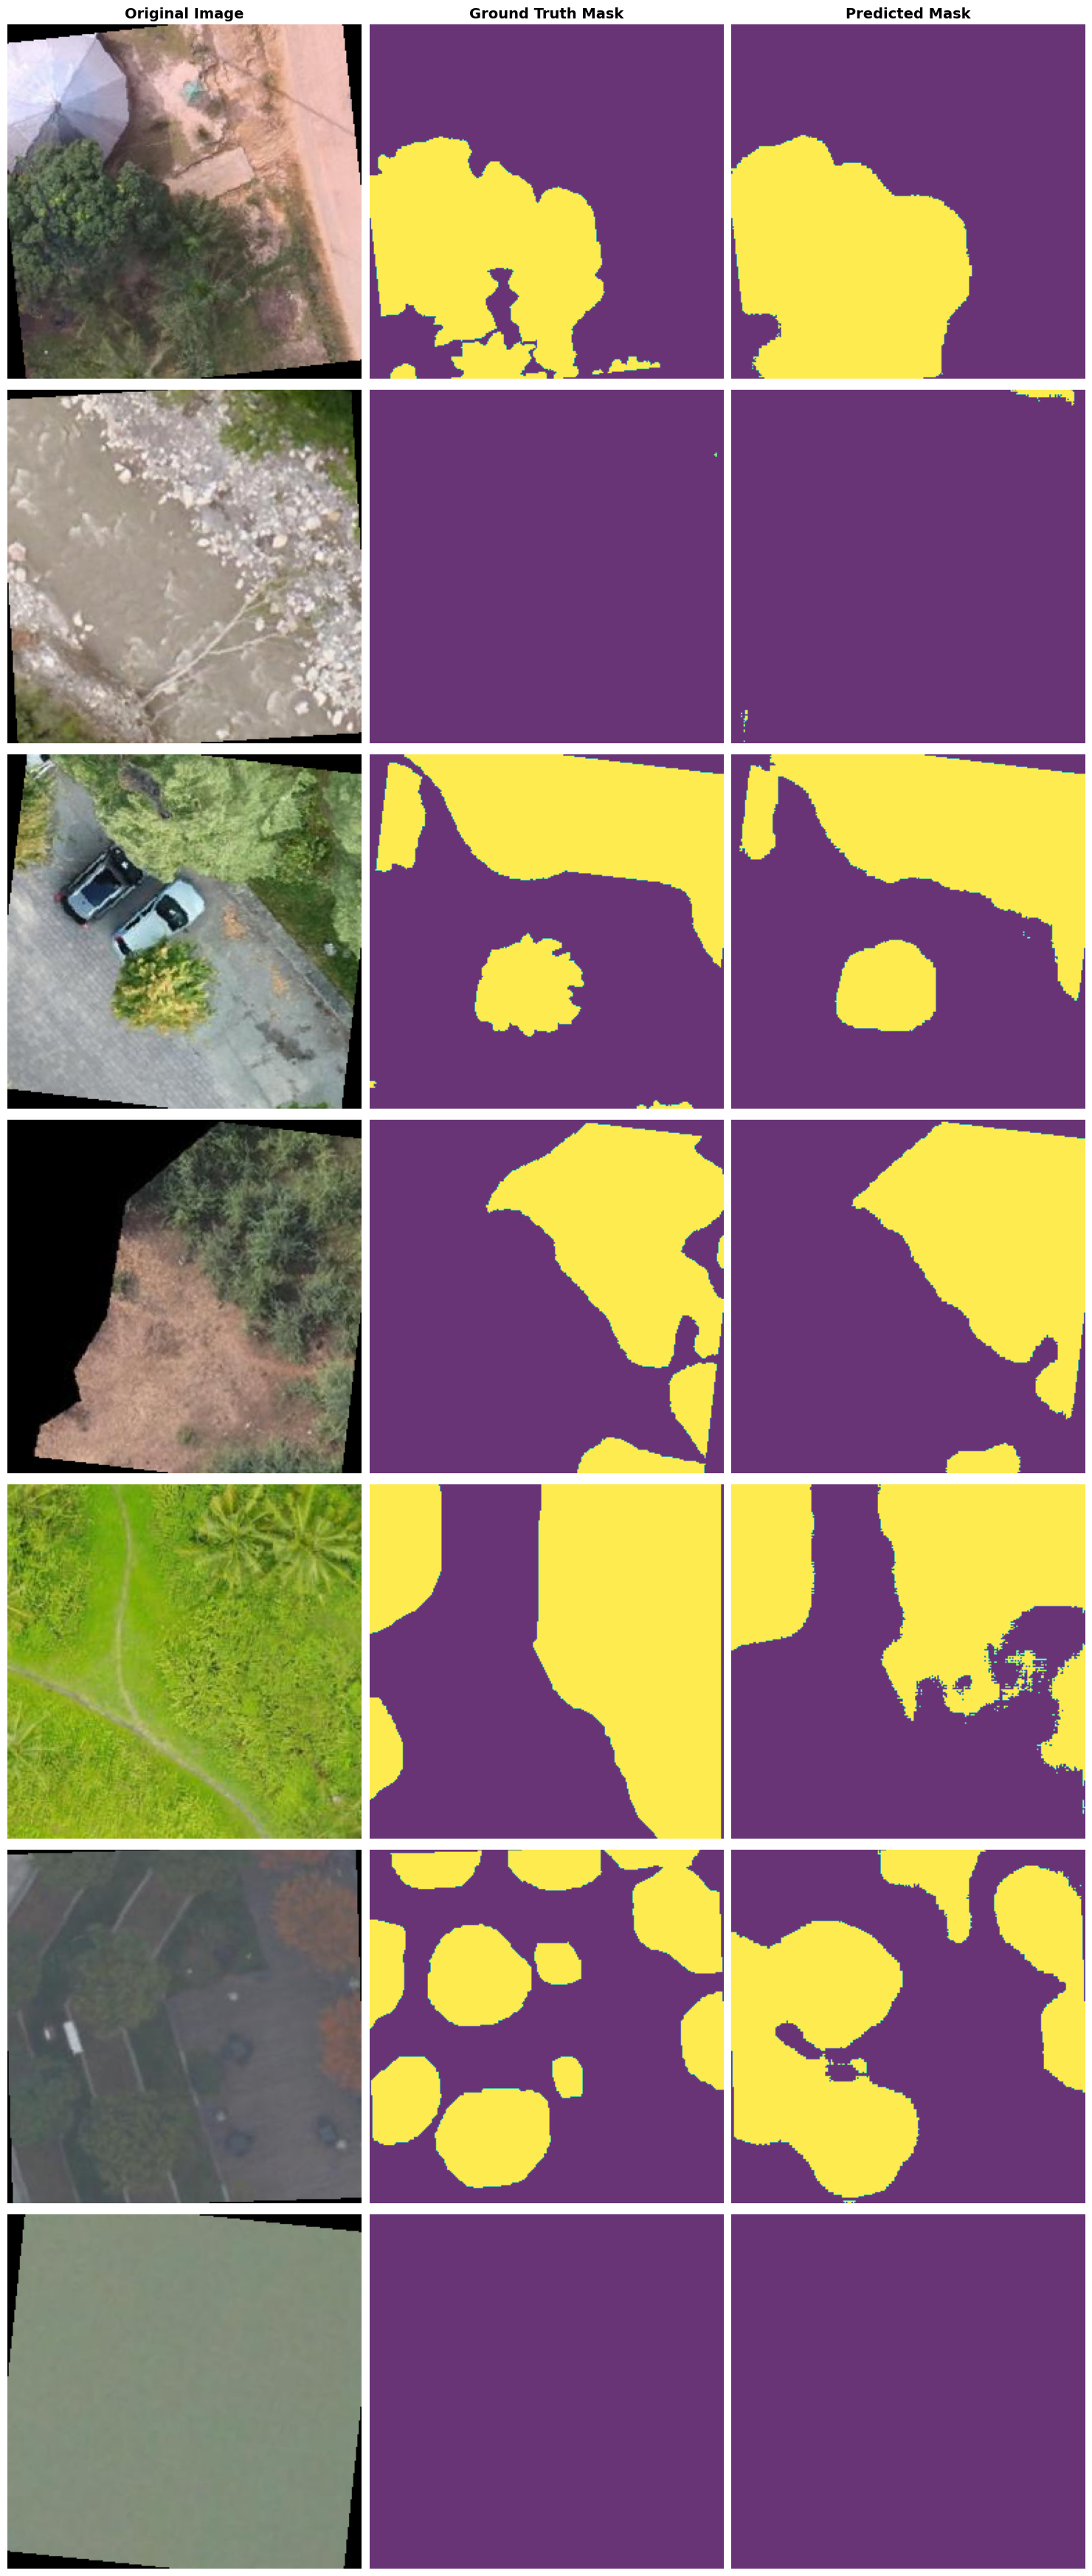


Per-Image Segmentation Metrics:
Image   Pixel Acc (%)  Dice Score  IoU Score   
-----------------------------------------------
1       94.09          0.6132      0.8765      
2       99.58          0.0000      0.4979      
3       94.38          0.6822      0.8874      
4       94.11          0.8009      0.8750      
5       78.24          0.5864      0.6411      
6       82.26          0.7375      0.6887      
7       100.00         0.0000      1.0000      

Average Pixel Accuracy: 91.81%
Average Dice Score: 0.4886
Average IoU Score: 0.7809


In [21]:
visualize_segmentation_results_colored(seg_model, seg_val_loader, device, num_images = 7)